# *** Clean-up of GIS data to be used in SFRmaker scripts(s). ***

As I was struggling with NBr37, I decided it'd be a good idea to first clean-up the GIS data and save them to a cleaned-up file, and only then use them in the SFRmaker scripts.

# 0. Imports

In [1]:
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import shutil as sh
import pandas as pd
from datetime import datetime as DT
import matplotlib.pyplot as plt
from pathlib import Path
import re

In [2]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM
import WS_Mdl.calcs as C
import WS_Mdl.geo as G
from WS_Mdl.utils import bold, style_reset

In [3]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)
IL.reload(G)

<module 'WS_Mdl.geo' from 'G:\\code\\WS_Mdl\\geo.py'>

In [4]:
# Import sfrmaker and other necessary packages for SFR network creation
import geopandas as gpd
import numpy as np
import xarray as xr
import shapely
from shapely.geometry import LineString, MultiLineString, box
from shapely.ops import linemerge, split, unary_union

In [5]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

In [6]:
import imod

# 1. Options

In [7]:
Pa_Gpkg_In = U.Pa_WS + r"\models\NBr\PrP\SFR\BrabantseDelta\acceptatiedatabase.gdb"
detailed = 'hydroobject'
primary = 'LEGGER_VASTGESTELD_WATERLOOP_CATEGORIE_A'
MdlN = 'NBr37'
Pa_Out = PJ(U.Pa_WS, r"models\NBr\PrP\SFR\BrabantseDelta\Gpkg\WBD_detail_SW_NW_cleaned.gpkg") #111

In [8]:
U.set_verbose(False)
# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax, cellsize, N_R, N_C = U.Mdl_Dmns_from_INI(d_Pa['INI'])
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])
U.Mdl_Dmns_from_INI(d_Pa['INI'])

(113100.0, 387600.0, 125100.0, 396200.0, 25.0, 344, 480)

In [9]:
l_X_Y_Cols = ['Xa', 'Ya', 'Xz', 'Yz']

# 2. Create SFR lines

## 2.1.Load

In [10]:
A0 = gpd.read_file(Pa_Gpkg_In, layer=detailed) # A is the primary Gpkg layer #111
A0_ = A0.copy()

## 2.2. Review

### 2.2.0 Create X & Y columns

In [11]:
A1 = U.Calc_GDF_XY_start_end_from_Geom(A0)

### 2.2.1 .describe()

In [12]:
A1.shape

(40811, 111)

In [13]:
A1.describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


It's clear that a lot of the columns have very little data. So I will remove those columns as there isn't much we can do with them, but it would take time to analyze them.

### 2.2.2 Check number of values and remove columns with little data.

In [14]:
U.DF_Col_value_counts_grouped(A1, percentile_step=10)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


This confirms that most columns have very few values. We'll drop all columns that have fewer valid values than 10% of the length of the DataFrame.

In [15]:
l_GDF_Cols_to_keep = [col for col in A1.columns if A1[col].notnull().sum() >= (0.1 * len(A1))]
print(f"{len(l_GDF_Cols_to_keep)}/{A1.shape[1]} columns kept in A1.")
A2 = A1[l_GDF_Cols_to_keep].copy()

31/111 columns kept in A1.


A lot of columns remain, but their number has reduced a lot. Let's check them, and decide which to keep. We'll proceed with a joint GDF called GDF.

In [16]:
A2.shape

(40811, 31)

### 2.2.3 Narrow down to SFRmaker columns.

Truth is we only need a few columns for SFRmaker to work. We'll proceed with just those columns, but the rest could potentially be reviewed and saved as a .shp/.gpkg file later on.

In [17]:
A2.describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


1. **CODE**:                        OK           -          All unique, as we want them to be.
2. **WS_STATUS_L**:                 OK           -          All filled. Seems ok.
3. **WS_LEGGERCATEGORIE_L**:        OK           -          "   "   "
4. **WS_LEGGERBRON_L**:             OK           -          
5. **DATUM_VASTGESTELD**:           OK           -           
6. **LEGGER_KENMERK**:              OK           -           
7. **WS_BODEMBREEDTE_L**:           OK           -           
8. **WS_BH_BOVENSTROOMS_L**:        OK           -           
9. **WS_BH_BENEDENSTROOMS_L**:      OK           -           
10. **WS_TALUD_LINKS_L**:           OK           -           
11. **WS_TALUD_RECHTS_L**:          OK           -           
12. **WS_BIJZ_FUNCTIE_L**:          OK           -           
13. **WIJZIGING**:                  OK           -           
14. **CREATED_USER**:               OK           -           
15. **CREATED_DATE**:               OK           -           
16. **LAST_EDITED_USER**:           OK           -           
17. **LAST_EDITED_DATE**:           OK           -           
18. **WS_LEGGERVERWIJZING_L**:      OK           -           
19. **SHAPE_Length**:               OK           -           
20. **geometry**:                   OK           -           
21. **Xstart**:                     OK           -           
22. **Ystart**:                     OK           -           
23. **Xend**:                       OK           -           
24. **Yend**:                       OK           -           

In [18]:
A3 = A2[['CODE', 'WS_BODEMBREEDTE_L', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L', 'SHAPE_Length', *l_X_Y_Cols, 'geometry',]].copy()

In [19]:
A3.rename(columns={'WS_BODEMBREEDTE_L': 'width',
                  'WS_BH_BOVENSTROOMS_L': 'Elv_UStr',
                  'WS_BH_BENEDENSTROOMS_L': 'Elv_DStr',
                  'SHAPE_Length': 'length'}, inplace=True)

### 2.2.4 Fill CODE
The CODE column is not full. We'll add dummy codes where missing. (although they should have been there in the first place)

In [20]:
A3['CODE']

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [21]:
A3.loc[ A3['CODE'].isnull(), 'CODE' ] = [f'dummy_{i}' for i in range(1, A3['CODE'].isnull().sum() + 1)]

## 2.3. Split

### 2.3.0 Def function

In [22]:
def split_lines_by_neighbors(gdf: gpd.GeoDataFrame, tol: float = 0.000001) -> gpd.GeoDataFrame:
    """
    Split each (Multi)LineString where it meets OTHER features in gdf.
    Uses a spatial index so only intersecting neighbors are used as splitters.
    Returns one row per split segment, attributes copied from the original row.
    tol in CRS units (e.g. meters).
    """
    gdf = gdf.copy()
    geom_col = gdf.geometry.name
    other_cols = [c for c in gdf.columns if c != geom_col]
    gdf['_original_geom'] = gdf[geom_col].copy() # Store original geometries

    # Snap Cooinates so near-coincident nodes match (for spatial index and splitting)
    if hasattr(shapely, "set_precision"):
        gdf[geom_col] = shapely.set_precision(gdf[geom_col].array, tol)

    sindex = gdf.sindex

    new_rows = []

    for idx, row in gdf.iterrows():
        geom = row[geom_col]
        original_geom = row['_original_geom']
        attrs = row.to_dict()

        # candidate neighbors that intersect this geom's bbox
        cand_idx = list(sindex.query(geom, predicate="intersects"))
        cand_idx = [i for i in cand_idx if i != idx]

        if not cand_idx:
            # No neighbors - use original unsnapped geometry
            new_rows.append({**attrs, geom_col: original_geom})
            continue

        neigh_geoms = gdf.loc[cand_idx, geom_col].values

        # build splitter from neighbors
        splitter = unary_union(neigh_geoms)

        # NEW: remove overlapping segments so split() only sees crossing/touching parts
        splitter = splitter.difference(geom)

        if splitter.is_empty or not geom.intersects(splitter):
            # Has neighbors but no actual split - use original unsnapped geometry
            new_rows.append({**attrs, geom_col: original_geom})
            print(row['CODE'], "no split")
            continue

        parts = split(geom, splitter)

        # Check if geometry was actually split (more than 1 part)
        if len(parts.geoms) == 1:
            # Not actually split - use original unsnapped geometry
            new_rows.append({**attrs, geom_col: original_geom})
        else:
            # Geometry was actually split - use snapped version
            for seg in parts.geoms:
                new_rows.append({**attrs, geom_col: seg})

    # Return without _original_geom column
    return gpd.GeoDataFrame(new_rows, columns=other_cols + [geom_col], crs=gdf.crs)

### 2.3.1 Split and QA

In [23]:
A4 = split_lines_by_neighbors(A3, tol=0.001)

OWL40573 no split


In [24]:
# A4_ = A4.copy()
# num_cols = A4_.select_dtypes(include=[np.number]).columns
# A4_[num_cols] = A4_[num_cols].round(3)
# A4_.to_file('A4.gpkg')

In [25]:
# Diagnostic: Check coordinates preservation
# Compare A3 (before split) with non-split rows in A4
A4_codes = A4['CODE'].value_counts()
non_split_codes = A4_codes[A4_codes == 1].index  # Codes that weren't split

# Get non-split rows from A4
A4_non_split = A4[A4['CODE'].isin(non_split_codes)].copy()
A3_matching = A3[A3['CODE'].isin(non_split_codes)].copy()

# Extract coordinates
A3_matching = A3_matching.set_index('CODE')
A4_non_split = A4_non_split.set_index('CODE')

# Check coordinate differences
Coo_diff = 0
for code in non_split_codes:
    if code in A3_matching.index and code in A4_non_split.index:
        g3 = A3_matching.loc[code, 'geometry']
        g4 = A4_non_split.loc[code, 'geometry']
        
        # Extract start and end coordinates properly for both LineString and MultiLineString
        if g3.geom_type == 'LineString':
            c3 = (g3.coords[0], g3.coords[-1])
        else:  # MultiLineString
            c3 = (g3.geoms[0].coords[0], g3.geoms[-1].coords[-1])
        
        if g4.geom_type == 'LineString':
            c4 = (g4.coords[0], g4.coords[-1])
        else:  # MultiLineString
            c4 = (g4.geoms[0].coords[0], g4.geoms[-1].coords[-1])
        
        if c3 != c4:
            Coo_diff += 1

print(f"Total non-split features: {len(non_split_codes)}")
print(f"Non-split features with changed coordinates: {Coo_diff}")
print(f"Total features in A3: {len(A3)}")
print(f"Total features in A4: {len(A4)}")
print(f"Features that were split: {len(A4) - len(non_split_codes)}")


Total non-split features: 29094
Non-split features with changed coordinates: 0
Total features in A3: 40811
Total features in A4: 60927
Features that were split: 31833


In [26]:
l_X_Y_Cols_ = [i+'_' for i in l_X_Y_Cols]
l_Cols1 = sorted(['CODE', *l_X_Y_Cols, *l_X_Y_Cols_, 'geometry'])

In [27]:
A4[l_X_Y_Cols_] = A4.geometry.apply(
    lambda g: pd.Series(
        g.geoms[0].coords[0] + g.geoms[-1].coords[-1]
        if g.geom_type.startswith("Multi")
        else g.coords[0] + g.coords[-1],
        index=l_X_Y_Cols_
    )
)

In [28]:
A4['split'] = 0
A4_split = A4.loc[ A4['CODE'].isin(A4['CODE'].value_counts()[A4['CODE'].value_counts() > 1].index)]
A4.loc[ A4['CODE'].isin(A4['CODE'].value_counts()[A4['CODE'].value_counts() > 1].index), 'split' ] = 1

In [29]:
A4_Coo_change = A4.loc[ (A4['Xa'].round(3)  != A4['Xa_'].round(3)) | # Only contains rows where coordinates have changed
                        (A4['Ya'].round(3)  != A4['Ya_'].round(3)) | 
                        (A4['Xz'].round(3)    != A4['Xz_'].round(3)) | 
                        (A4['Yz'].round(3)    != A4['Yz_'].round(3)) ]

In [30]:
A4_split.shape, A4_Coo_change.shape, A4.shape

((31833, 15), (31771, 15), (60927, 15))

In [31]:
# pd.DataFrame( {'CODE': A4_split['CODE'].value_counts().index, 'counts': A4_split['CODE'].value_counts().values} ).groupby('counts').size()

In [32]:
shift = A4_Coo_change.loc[ ~A4_Coo_change['CODE'].isin(A4_split['CODE']), l_Cols1]

In [33]:
shift.shape

(0, 10)

- Shift being empty shows that no coordinates were changed, except for the CODEs that were split! As was desired.

In [34]:
# Identify rows in A4_split but not in A4_Coo_change
A4_split_no_Coo_change = A4_split.loc[~A4_split.index.isin(A4_Coo_change.index)].copy()
print(f"Rows in A4_split but not in A4_Coo_change: {len(A4_split_no_Coo_change)}")
print(f"\nUnique CODEs: {A4_split_no_Coo_change['CODE'].unique()}")
A4_split_no_Coo_change[l_Cols1]

Rows in A4_split but not in A4_Coo_change: 62

Unique CODEs: ['OWL15263' 'OWL36198' 'OWL26208' 'OVK07910' 'OWL03661' 'OWL01479'
 'OWL24648' 'OWL40004' 'OWL26755' 'OWL32345' 'OWL18160' 'OWL26155'
 'OWL17775' 'OWL36732' 'OWL00418' 'OWL12862' 'OVK05961' 'OWL35497'
 'OWL44731' 'OWL01474' 'OWL40813' 'OWL01609' 'OVK05421' 'OWL01346'
 'OVK10006' 'OWL25188' 'OWL32169' 'OWL06089' 'OVK08076' 'OWL41232'
 'OWL17672' 'OVK50390' 'OVK07672' 'OWL01801' 'OWL18107' 'OVK05228'
 'OWL25554' 'OWL36234' 'OVK02257' 'OWL40628' 'OWL37614' 'OWL35953'
 'OWL12677']


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


A few entries seem to have had their changed for one of the split sub-segments but not for the other. This shows some sort of false start and going back and forth. Let's check those.

In [35]:
for i, code in A4_split_no_Coo_change['CODE'].items():
    GDF_section = A4.loc[A4['CODE'] == code, l_Cols1] # .loc['CODE'] # .iloc[i-1]
    
    for j, R in GDF_section.iterrows():
        if not np.isclose(R['Xa'], R['Xa_']) or not np.isclose(R['Ya'], R['Ya_']) or not np.isclose(R['Xz'], R['Xz_']) or not np.isclose(R['Yz'], R['Yz_']):
            print(f'Coordinates have changed for {j}, {R["CODE"]}')
            print(GDF_section)
            # print(A4.loc[j, sorted(['CODE', *l_X_Y_Cols, *l_X_Y_Cols_, 'geometry'])])
            print('-'*50)
        # A4_split_no_Coo_change.loc[i, sorted(['CODE', *l_X_Y_Cols, *l_X_Y_Cols_, 'geometry'])]

Coordinates have changed for 312, OWL15263
         CODE          Xa         Xa_          Xz         Xz_         Ya  \
311  OWL15263  101417.223  101417.223  101207.194  101207.194  396420.34   
312  OWL15263  101417.223  101205.123  101207.194  101207.194  396420.34   
313  OWL15263  101417.223  101207.194  101207.194  101192.726  396420.34   

            Ya_          Yz         Yz_  \
311  396420.340  396537.119  396537.119   
312  396534.271  396537.119  396537.119   
313  396537.119  396537.119  396540.653   

                                              geometry  
311  LINESTRING (101417.223 396420.34, 101406.584 3...  
312  LINESTRING (101205.123 396534.271, 101207.194 ...  
313  LINESTRING (101207.194 396537.119, 101192.726 ...  
--------------------------------------------------
Coordinates have changed for 313, OWL15263
         CODE          Xa         Xa_          Xz         Xz_         Ya  \
311  OWL15263  101417.223  101417.223  101207.194  101207.194  396420.34   
312  

In [36]:
A4.loc[ A4['CODE'].isin(A4_split_no_Coo_change['CODE']), l_X_Y_Cols_ ] = A4.loc[ A4['CODE'].isin(A4_split_no_Coo_change['CODE']), l_X_Y_Cols ].values

Something weird is happending to those. I'll proceed as is for now. Maybe later I'll come back to it. # 666

### 2.3.3 Recalc/assign some columns

In [37]:
A4_split['CODE'].value_counts()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


#### Length

In [38]:
A4.loc[A4['CODE']=='OVK03536']

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Length needs to be recalculated after the split, based on the new geometries. As you can see above, all lengths for split segments are currently the same as the original segment length.

In [39]:
A5 = A4.copy()

In [40]:
A5['length'] = A5.geometry.length

In [41]:
A5.loc[A4['CODE']=='OVK03536', 'length']

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [42]:
A5.loc[A4['CODE']=='OVK03536', 'length'].sum().round(3), A4.loc[A4['CODE']=='OVK03536','length'].iloc[0].round(3)

(np.float64(621.801), np.float64(621.99))

The length sum isn't exactly identical, but I'll move forward for now. #666 can come back to this later

#### Coordinates

In [43]:
Bool_Coo_changed = (A5[l_X_Y_Cols].sum(axis=1)!=A5[l_X_Y_Cols_].sum(axis=1))

In [44]:
A5.loc[Bool_Coo_changed, l_X_Y_Cols] = A5.loc[Bool_Coo_changed, l_X_Y_Cols_].values

In [45]:
(A5.loc[:, l_X_Y_Cols].values == A5.loc[:, l_X_Y_Cols_].values).all()

np.True_

All values from the newly calculated coordinates have been assigned to the main GDF.

In [46]:
A5.drop(columns=l_X_Y_Cols_ , inplace=True)

In [47]:
A5.loc[ A5['split']==1, ['CODE', 'Elv_UStr', 'Elv_DStr'] ]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


## 2.4 Fill NaN values for width, Elv_UStr, Elv_DStr 

### 2.4.0 Investigate

In [48]:
A5.shape

(60927, 11)

In [49]:
A5.describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


### 2.4.1 Width

Width will be set to 1m where missing. This is very simplistic, but a good start. #666

In [50]:
A5.loc[ A5['width'].isnull(), 'width'  ] = 1.0

### 2.4.2 Elv

We'll assign Elv_UStr and Elv_DStr based on layer 1 top and bottom elevations.

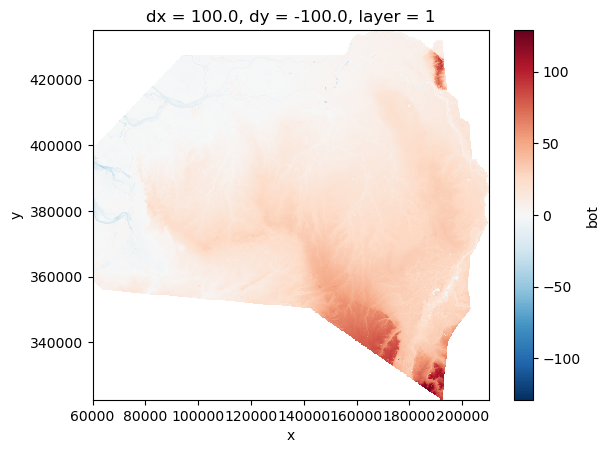

In [51]:
Pa_BOT = r"g:\\models\\NBr\\In\\BOT"
l_BOT = [PJ(Pa_BOT, i) for i in LD(Pa_BOT) if i.lower().endswith('.idf')]
BOT = imod.formats.idf.open(l_BOT, pattern="{name}_L{layer}_")
BOT_L1 = BOT.sel(layer=1)
BOT_L1.plot()

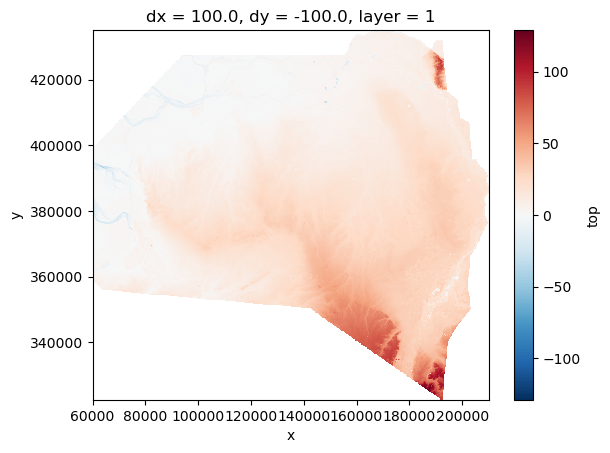

In [52]:
Pa_TOP = r"g:\\models\\NBr\\In\\TOP"
l_T = [PJ(Pa_TOP, i) for i in LD(Pa_TOP) if i.lower().endswith('.idf')]
TOP = imod.formats.idf.open(l_T, pattern="{name}_L{layer}_")
TOP_L1 = TOP.sel(layer=1)
TOP_L1.plot()

In [53]:
UIM.xr_describe(BOT_L1)

--- Statistics for: bot ---
count    1.129260e+06
mean     1.647475e+01
std      1.699688e+01
min     -4.214910e+01
25%      3.192075e+00
50%      1.371000e+01
75%      2.594000e+01
max      1.289800e+02
Name: bot, dtype: float64

--- Coordinate Summary ---
- x (float64):
count      1503.0
min       60050.0
max      210250.0
step        100.0

- y (float64):
count      1126.0
min      322550.0
max      435050.0
step       -100.0

------------------------------


In [54]:
UIM.xr_describe(TOP_L1)

--- Statistics for: top ---
count    1.129260e+06
mean     1.695195e+01
std      1.669670e+01
min     -4.210010e+01
25%      3.990000e+00
50%      1.395000e+01
75%      2.612000e+01
max      1.290300e+02
Name: top, dtype: float64

--- Coordinate Summary ---
- x (float64):
count      1503.0
min       60050.0
max      210250.0
step        100.0

- y (float64):
count      1126.0
min      322550.0
max      435050.0
step       -100.0

------------------------------


In [55]:
L1_Thk = TOP.sel(layer=1) - BOT.sel(layer=1)

In [56]:
UIM.xr_describe(L1_Thk)

--- Statistics for: DataArray ---
count    1.129260e+06
mean     4.809466e-01
std      1.223881e+00
min      9.998322e-03
25%      4.999924e-02
50%      5.000019e-02
75%      3.808000e-01
max      6.173900e+01
Name: DataArray, dtype: float64

--- Coordinate Summary ---
- x (float64):
count      1503.0
min       60050.0
max      210250.0
step        100.0

- y (float64):
count      1126.0
min      322550.0
max      435050.0
step       -100.0

------------------------------


In [57]:
# for l in range(1, 8):
#     print(f"*** Layer {l} thickness stats:")
#     L_Thk = TOP.sel(layer=1) - BOT.sel(layer=l)
#     UIM.xr_describe(L_Thk)
#     print('-'*40)

In [58]:
L1_middle = (BOT_L1 + TOP_L1) / 2

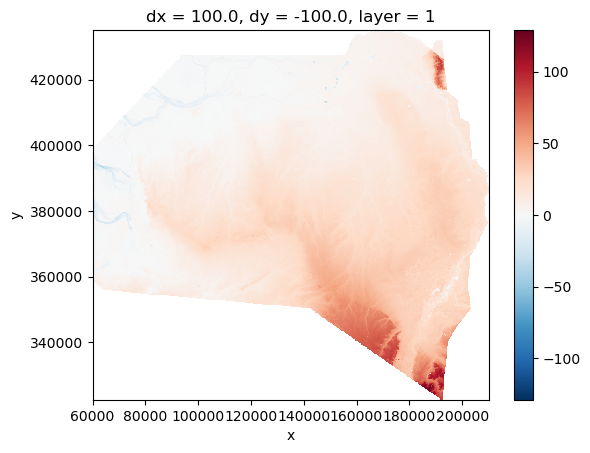

In [59]:
L1_middle.plot()

In [60]:
UIM.xr_describe(L1_middle)

--- Statistics for: DataArray ---
count    1.129260e+06
mean     1.671280e+01
std      1.683645e+01
min     -4.212460e+01
25%      3.475500e+00
50%      1.382600e+01
75%      2.602500e+01
max      1.290050e+02
Name: DataArray, dtype: float64

--- Coordinate Summary ---
- x (float64):
count      1503.0
min       60050.0
max      210250.0
step        100.0

- y (float64):
count      1126.0
min      322550.0
max      435050.0
step       -100.0

------------------------------


In [61]:
# Fill NaN values in A5's Elv_UStr and Elv_DStr from L1_middle
# by matching coordinates (Xa, Ya) and (Xz, Yz) respectively

import numpy as np

# Get masks for NaN values
nan_ustr_mask = A5['Elv_UStr'].isna()
nan_dstr_mask = A5['Elv_DStr'].isna()

print(f"Filling {nan_ustr_mask.sum()} NaN values in Elv_UStr...")
print(f"Filling {nan_dstr_mask.sum()} NaN values in Elv_DStr...")

# Fill Elv_UStr using upstream coordinates (Xa, Ya)
if nan_ustr_mask.any():
    # Get coordinates for rows with NaN Elv_UStr
    xa_vals = A5.loc[nan_ustr_mask, 'Xa'].values
    ya_vals = A5.loc[nan_ustr_mask, 'Ya'].values
    
    # Sample L1_middle at each coordinate pair individually
    elv_ustr_filled = np.array([L1_middle.sel(x=x, y=y, method='nearest').values.item() 
                                for x, y in zip(xa_vals, ya_vals)])
    
    # Fill the NaN values
    A5.loc[nan_ustr_mask, 'Elv_UStr'] = elv_ustr_filled

# Fill Elv_DStr using downstream coordinates (Xz, Yz)
if nan_dstr_mask.any():
    # Get coordinates for rows with NaN Elv_DStr
    xz_vals = A5.loc[nan_dstr_mask, 'Xz'].values
    yz_vals = A5.loc[nan_dstr_mask, 'Yz'].values
    
    # Sample L1_middle at each coordinate pair individually
    elv_dstr_filled = np.array([L1_middle.sel(x=x, y=y, method='nearest').values.item() 
                                for x, y in zip(xz_vals, yz_vals)])
    
    # Fill the NaN values
    A5.loc[nan_dstr_mask, 'Elv_DStr'] = elv_dstr_filled

print("✓ Elevation filling completed!")

# Check results
print(f"Remaining NaN values in Elv_UStr: {A5['Elv_UStr'].isna().sum()}")
print(f"Remaining NaN values in Elv_DStr: {A5['Elv_DStr'].isna().sum()}")

Filling 39605 NaN values in Elv_UStr...
Filling 39603 NaN values in Elv_DStr...
✓ Elevation filling completed!
Remaining NaN values in Elv_UStr: 0
Remaining NaN values in Elv_DStr: 0


In [62]:
L1_middle.rio.to_raster('L1_middle.tif')

CPLE_AppDefinedError: Deleting L1_middle.tif failed: Permission denied

In [63]:
A5.loc[ A4['Elv_UStr'].isnull() & A4['Elv_DStr'].isnull(), ['CODE', 'Elv_UStr', 'Elv_DStr'] ]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [64]:
A5

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Checking in QGIS confirms that the Elvs were assigned properly.

## 2.5. Calculate routing

### 2.5.0 Create ID Col & Identify downstream

In [ ]:
A5.columns

In [ ]:
A5['ID'] = range(1, len(A5)+1)

In [ ]:
# Create a lookup dictionary from start coordinates to CODE
Coo_to_id = {(R.Xa, R.Ya): (R.CODE, R.ID) for R in A5.itertuples()}

print(f"✓ Lookup dictionary created with {bold}{len(Coo_to_id)}{style_reset} entries.")

In [ ]:
# Function to find the downstream ID
def get_DStr(row):
    end_Coos = (row.Xz, row.Yz)
    result = Coo_to_id.get(end_Coos, (0, 0))
    return result

# Apply the function to create the 'DStr' column
A5[['DStr_code', 'DStr_ID']] = A5.apply(get_DStr, axis=1, result_type='expand')

print("✓ 'DStr' columns calculated.")

In [ ]:
print(f'{round(A5['DStr_code'].value_counts().max()/A5.shape[0]*100, 2)} % of DStrs are 0 (i.e. no start Cooinates match the end Cooinates of the current node).')

The percentage is much bigger than expected. Let's investigate.

### 2.5.1 Investigate segments that failed to connect

#### Check out number of matches/no matches

In [ ]:
A5['DStr_match'] = A5['DStr_code'].isin(A5['CODE'])
A5['DStr_code'].value_counts()

It makes sense that most nodes have just a few upstream nodes. 1353 nodes are not connected.

In [ ]:
A5['DStr_match'].value_counts()

#### Calculate min distance from start to any reach's end and investigate no matches.

In [ ]:
A5['min_Dist'] = 0.0
A5.loc[A5['DStr_code'] == 0, 'min_Dist'] = A5.loc[A5['DStr_code'] == 0].apply(lambda row: C.c_Dist(row['Xz'], row['Yz'], A5['Xa'], A5['Ya']).min(), axis=1)

In [ ]:
N_total_no_match = (A5['DStr_code'] == 0).sum()

In [ ]:
A5.loc[A5['DStr_match']==False,'min_Dist'].describe()

In [ ]:
l_Vals = [0.001, 0.1, 1, 10, 100, 1000, 10000]

print(f'Out of the {N_total_no_match} segments that do not match:')

N_below_Prv, Val_Prv = 0, 0
for v in l_Vals:
    N_below = (A5.loc[A5['DStr_match']==False,'min_Dist'] <= v).sum()
    P_below = round(N_below / N_total_no_match * 100, 2)
    
    sample_A5 = A5.loc[(A5['min_Dist'] > Val_Prv) & (A5['min_Dist'] <= v), ['CODE', 'min_Dist']].sort_values(by='min_Dist')
    sample_A5['Code:min_Dist'] = sample_A5.apply(lambda row: f"{row['CODE']}: {row['min_Dist']:8.4f}", axis=1)
    sample_A5 = sample_A5['Code:min_Dist']
    example_nodes = sample_A5.iloc[:].tolist()

    print(f'-{Val_Prv:6} < min_Dist <= {v:5} |N: {N_below:6} (+ {(N_below - N_below_Prv):4}) ({round(P_below,1):5} %) | Codes: {example_nodes}\n')

    N_below_Prv, Val_Prv = N_below, v

The total number of segments that do not match is too high to check them all, but we'll check some cases.

- The following information hasn't been checked. Proceeding for now #666.
- The ones <1m can be attributed to closing errors, and we can connect them to the closest one via an algorithm.
- They take up 86% of the unmatched, which means there aren't that many remaining.
- Let's print out the names of the bigger differences, so that we can check them in QGIS.
    - Some of the smallest min_Dist values, e.g. OVK08923 are clearly closing errors.
    - Checking some fo the biggest values <1m, e.g. OVK09435, OVK05835, OVK02702, shows that they are also closing errors.

In [ ]:
A5.loc[A5['min_Dist'].between(1,10, inclusive='right'), ['CODE', 'min_Dist']].sort_values(by='min_Dist').reset_index(drop=True)

- The following information hasn't been checked. Proceeding for now #666.
- Some of the 1-10m differences, e.g. OVK06539, OVK08754, OVK21755, should have been connected to a downstream segment, but they were not.
- Others, like OVK05556, OVK00509, lead outside the area of the model.
- We can't check them all now, I'll only check those inside the model area that I'm innterested in.

In [ ]:
A5_within = A5.loc[A5.within(box(Xmin, Ymin, Xmax, Ymax))]

In [ ]:
A5_within.loc[ A5_within['min_Dist'].between(0,1, inclusive='right')]

In [ ]:
A5_within.loc[ A5_within['min_Dist'].between(1,10000, inclusive='right')]

There are also no items in our region with distances between 1m and 10km. We'll ignore those for now. Further analysis can be performed later, if there is interest in expanding the region. #666

### 2.5.2 Edit connections

In [ ]:
# Initialize the 'multiple_close' column with empty strings
A5['multiple_close'] = ""

# Select rows to correct
rows_to_correct = A5[(A5['DStr_code'] == 0) & (A5['min_Dist'] < 1)].copy()

print(f"Found {len(rows_to_correct)} segments with no downstream connection and a potential connection within 1m.")

corrected_count = 0
multiple_count = 0

# Loop through the rows that need correction
for i, R in rows_to_correct.iterrows():
    # Calculate distances from the current row's end point to all other rows' start points
    distances = C.c_Dist( R['Xz'], R['Yz'], A5['Xa'], A5['Ya'])
    
    # Find segments where the distance is less than 1m
    close_mask = (distances < 1) & (A5.index != i) # Exclude self
    close_segments_codes = A5['CODE'][close_mask].tolist()
    close_segments_object_ids = A5['ID'][close_mask].tolist()
    
    if len(close_segments_codes) == 1:
        # If there is exactly one close segment, update both 'DStr_code' and 'DStr_ID'
        A5.loc[i, 'DStr_code'] = close_segments_codes[0]
        A5.loc[i, 'DStr_ID'] = close_segments_object_ids[0]
        corrected_count += 1
    elif len(close_segments_codes) > 1:
        # If there are multiple close segments, store as comma-separated string
        A5.loc[i, 'multiple_close'] = ", ".join(close_segments_codes)
        multiple_count += 1

print(f"✓ Corrected {corrected_count} segments by updating 'DStr_code' and 'DStr_ID'.")
print(f"✓ Found {multiple_count} segments with multiple potential connections (stored in 'multiple_close').")

In [ ]:
A5_within = A5.loc[A5.within(box(Xmin, Ymin, Xmax, Ymax))]

In [ ]:
A5_within.loc[A5_within['multiple_close']!='', ['CODE', 'multiple_close']].sort_values(by='multiple_close', ascending=False)

I'll conect those randomly to one of the segments

In [ ]:
A5.columns

In [ ]:
A5.loc[ A5['CODE'].isin(A5_within['CODE']) & (A5['multiple_close']!='') , 'multiple_close']

In [ ]:
A5.loc[A5['CODE'].isin(A5_within['CODE']), ['DStr_code', 'DStr_ID']].shape

In [ ]:
within_and_multiple = A5['CODE'].isin(A5_within['CODE']) & (A5['multiple_close']!='')
A5.loc[ within_and_multiple.index, 'DStr_code']= A5.loc[ within_and_multiple , 'multiple_close'].str.split(', ').str[0]

In [ ]:
A5.loc[ within_and_multiple , 'multiple_close'].str.split(', ').str[0]

In [ ]:
A5.loc[ within_and_multiple, ['CODE']] == A5.loc[ within_and_multiple, ['DStr_code']]

In [ ]:
A5.loc[ within_and_multiple]

In [ ]:
within_and_multiple

In [ ]:
A5.loc[A5['CODE']=='OVK00976', ['DStr_code', 'DStr_ID']] = ['OVK01474', A5.loc[A5['CODE']=='OVK01474', 'ID'].values[0]]

In [ ]:
# Assign DStr_ID based on DStr_code for within_and_multiple segments
# Create a mapping from CODE to ID within A5
code_to_id_mapping = A5.set_index('CODE')['ID'].to_dict()

# Assign DStr_ID by looking up the DStr_code in the mapping
A5.loc[within_and_multiple, 'DStr_ID'] = A5.loc[within_and_multiple, 'DStr_code'].map(code_to_id_mapping)

In [ ]:
# Verify the DStr_ID assignment
A5.loc[within_and_multiple, ['CODE', 'DStr_code', 'DStr_ID']].head(10)

In [ ]:
A5.loc[A5['CODE']=='OVK50040', 'ID']

In [ ]:
# Check for any missing DStr_ID values after assignment
missing_dstr_id = A5.loc[within_and_multiple, 'DStr_ID'].isna().sum()
print(f"Number of segments with missing DStr_ID after assignment: {missing_dstr_id}")

if missing_dstr_id > 0:
    print("Segments with missing DStr_ID:")
    print(A5.loc[within_and_multiple & A5['DStr_ID'].isna(), ['CODE', 'DStr_code', 'DStr_ID']])

## 2.6 Correct Elv_UStr and Elv_DStr

In [ ]:
l_A5_Cols = ['ID', 'CODE', 'width', 'length', 'Elv_UStr', 'Elv_DStr', 'DStr_code', 'DStr_ID', 'Xa', 'Ya', 'Xz', 'Yz', 'geometry', 'split']

In [ ]:
A5.loc[A5['split']==1, l_A5_Cols]

In [ ]:
# A5_ = A5.copy()
# num_cols = A5_.select_dtypes(include=[np.number]).columns
# A5_[num_cols] = A5_[num_cols].round(3)
# A5_.to_file('A5.gpkg')

In [ ]:
A5['CODE'].value_counts()

In [ ]:
l_success, l_infinite_loop, l_closing_error = [], [], []

In [ ]:
A5.columns

In [ ]:
A6 = A5.copy()[['ID', 'DStr_ID',  'width', 'length', 'Elv_UStr', 'Elv_DStr', 'Xa', 'Ya', 'Xz', 'Yz', 'geometry', 'CODE','DStr_code', 'split']]

In [ ]:
A6.shape

In [ ]:
A6.describe()

In [ ]:
A3.describe()

In [ ]:
A3.shape, A5.shape, A6.shape

In [ ]:
# NaN Elvs need to be filled in A3 too, if it is to e used for Elv corrections
A3_ = A3.copy()

In [ ]:
A3_Elv_NaN_codes = A3_.loc[ A3_['Elv_UStr'].isnull() | A3_['Elv_DStr'].isnull(), 'CODE' ].unique() # list of codes where Elv is NaN

In [ ]:
A5_Elv_NaN_in_A3 = A5.loc[ A5['CODE'].isin(A3_Elv_NaN_codes), ['CODE', 'Elv_UStr', 'Elv_DStr'] ] # DF for those codes

In [ ]:
A5_Elv_UStr_max = A5_Elv_NaN_in_A3.groupby( ['CODE'])['Elv_UStr'].max()
A5_Elv_DStr_min = A5_Elv_NaN_in_A3.groupby( ['CODE'])['Elv_DStr'].min()

In [ ]:
A3_.loc[ A3_['CODE'].isin(A3_Elv_NaN_codes), 'Elv_UStr' ] = A3_.loc[ A3_['CODE'].isin(A3_Elv_NaN_codes), 'CODE' ].map( A5_Elv_UStr_max )

In [ ]:
A3_.loc[ A3_['CODE'].isin(A3_Elv_NaN_codes), 'Elv_DStr' ] = A3_.loc[ A3_['CODE'].isin(A3_Elv_NaN_codes), 'CODE' ].map( A5_Elv_DStr_min )

In [ ]:
A3_.loc[ A3_['CODE'].isin(A3_Elv_NaN_codes)]

In [ ]:
# Attempt 3 # Other 2 in junkyard. This one worked, needs to be improved though. 
# n = 311
n = 1 
for i in A5.loc[ A5['split']==1, 'CODE'].unique(): #[::-1]: # [26:27]: #[n:n+1]:

    print(f"{i} - {n:4}/{len(A5.loc[ A5['split']==1, 'CODE'].unique()):4}", end=' - ')
    n += 1

    # Prep GDF and Se for CODE   
    GDF = A5.loc[A5['CODE']==i, l_A5_Cols] # Create GDF for the current CODE
    Se = A3_.loc[A3_['CODE']==i]
    Coo_a = (Se['Xa'].values[0], Se['Ya'].values[0])
    Coo_z = (Se['Xz'].values[0], Se['Yz'].values[0])

    # Prepare for Elv_DStr adjustment
    drop = Se['Elv_UStr'].values[0] - Se['Elv_DStr'].values[0]
    length = GDF['length'].sum()
    GDF['C'] = GDF['length'] / length
    
    # Iterate UStr to DStr and edit Elvs
    dx = GDF['Xa'] - Coo_a[0]; dy = GDF['Ya'] - Coo_a[1]
    idx = np.hypot(dx, dy).idxmin()
    ID_UStr = GDF.loc[[idx], 'ID'].values[0]      # or GDF.loc[idx] for a Series

    ID = ID_UStr
    while True:
        GDF.loc[ GDF['ID']==ID, 'Elv_DStr'] = GDF.loc[ GDF['ID']==ID, 'Elv_UStr'].values[0] - drop * GDF.loc[GDF['ID']==ID, 'C'].values[0]

        # Replace the problematic section with:
        distances_to_end = GDF.apply(lambda R: np.hypot(R.Xz - Coo_z[0], R.Yz - Coo_z[1]), axis=1)
        closest_to_end_idx = distances_to_end.idxmin()
        end_ID = GDF.loc[closest_to_end_idx, 'ID']

        if ID == end_ID:
            break
        
        Coo_prev = (GDF.loc[GDF['ID']==ID, 'Xz'].values[0], GDF.loc[GDF['ID']==ID, 'Yz'].values[0])
        ID_prev = ID
        try:
            ID = GDF.loc[ GDF.apply( lambda R: np.isclose((R.Xa, R.Ya), Coo_prev, atol=0.0001).all(), axis=1), 'ID' ].values[0]
            if ID == ID_prev:
                print(f"Stuck at ID {ID}. Breaking loop to avoid infinite iteration.")
                l_infinite_loop.append(i)
                break
        except IndexError:
            print(f"No matching ID found for coordinates {Coo_prev} in CODE {i}. Breaking loop.")
            l_closing_error.append(i)
            break

        # print(ID_prev, ID)
        GDF.loc[ GDF['ID']==ID, 'Elv_UStr' ] = GDF.loc[GDF['ID']==ID_prev, 'Elv_DStr'].values[0]

    # Check
    check = np.isclose( A3_.loc[A3_['CODE']==i, 'Elv_DStr'], GDF.loc[GDF['ID']==ID, 'Elv_UStr'].values[0] - drop * GDF.loc[GDF['ID']==ID, 'C'].values[0] , atol=0.1).any()
    if not check:
        print(f"Discrepancy in Elv_DStr for CODE {i}: calculated {GDF.loc[GDF['ID']==ID, 'Elv_DStr'].values[0]}, expected {A3_.loc[A3_['CODE']==i, 'Elv_DStr'].values[0]}")
        l_closing_error.append(i)
    else:
        print('Elvs calculated correctly.')
        l_success.append(i)
        A6.loc[A6['CODE']==i, 'Elv_UStr'] = GDF['Elv_UStr'].values
        A6.loc[A6['CODE']==i, 'Elv_DStr'] = GDF['Elv_DStr'].values

In [ ]:
len(l_success), len(l_infinite_loop), len(l_closing_error)

There are too many unsucessful, codes, but it's too late, so I'll pray it'll work the current Mdl Aa and continue.

In [ ]:
A6.columns

In [ ]:
Pa_Out

In [ ]:
A6.to_file(Pa_Out)

# -1. Junkyard

In [ ]:
# ### 2.2.3 Check CODE
# #### Uniqueness
# **This section was designed before the shapefiles were split. It's not valid anymore, hence most of the cells have been removed.**
# There shouldn't be any duplicates. Let's check those codes in QGIS.
# After checking in QGIS, I see that the longer OWL17672 item doesn't make sense. I'll simply remove it.
# GDF_detail.drop(GDF_detail[GDF_detail['CODE'] == 'OWL17672'].sort_values('SHAPE_Length').iloc[:1].index, inplace=True)
# ##### Check combined
# #### Codes Missing from detailed GDF
# A.loc[~A['CODE'].isin(GDF_detail['CODE'].values)]
# This is strange, I was expecting the detailed GDF to have all the codes from A, but their number is small. I'll check for those items on the map
# - **OVK02041**: is a small ditch, that for whatever reason isn't part of GDF_detail (there is nothing in that exact spot, but it's downstream segment is there). 
# - **OVK00911**: is the end part of OWL37987 in detail.
# - **OVK02271**, **OVK11550**, **OVK02270**: All 3 of those form a big segmet in detailed, but they're split in 1ry.
# ### 2.2.4 Merge
# GDF = pd.merge(GDF_detail, A, on='CODE', how='outer')  # was how='all'
# GDF_ = GDF.copy()
# GDF_detail.shape, A.shape, GDF.shape
# GDF[sorted([i for i in GDF.columns if 'geometry' not in i])].sort_values('WS_BH_BOVENSTROOMS')
# ### 2.2.5 Check
# #### Start
# Let's check if the _x, _y columns are identical. If yes, we can drop one of them.
# [i for i in GDF.columns if '_x' in i ]
# We're expecting 591 matches, as that's the number of values in A, and the same info was copied to GDF_detail.
# # def compare_GDF_columns(GDF, col_x, col_y=None):
# #     if type(col_x) is not list:
# #         col_x = [col_x]
# #     if not col_y:
# #         col_y = [i.replace('_x', '_y') for i in col_x]
# #     if type(col_y) is not list:
# #         col_y = [col_y]

# #     if all(i in GDF.columns for i in col_x) and all(i in GDF.columns for i in col_y):
# #         either_not_na = GDF[col_x + col_y].notna().any(axis=1)
# #         comparison = np.isclose(GDF.loc[either_not_na, col_x], GDF.loc[either_not_na, col_y], equal_nan=True).all(axis=1)
# #         num_equal = comparison.sum()
# #         print(f"Columns '{col_x, col_y}': {num_equal} values are equal.\nHere are the values that aren't equal:")

# #         display(GDF.loc[either_not_na].loc[ ~comparison, ['CODE', *col_x, *col_y]])
# #     else:
# #         print(f"Columns '{col_x, col_y}' not in GDF.columns.")
# def compare_GDF_columns(GDF, col_x, col_y=None, rtol=1e-5, hide_x_na=False, hide_y_na=False, atol=None):
#     if not col_y:
#         col_y = col_x.replace('_x', '_y')

#     if col_x in GDF.columns and col_y in GDF.columns:
#         l_na_to_remove = [col_x, col_y]
#         if hide_x_na: l_na_to_remove.remove(col_y)
#         if hide_y_na: l_na_to_remove.remove(col_x)

#         either_not_na = GDF[l_na_to_remove].notna().any(axis=1)
#         if atol:
#             comparison = np.isclose(GDF.loc[either_not_na, col_x], GDF.loc[either_not_na, col_y], atol=atol, equal_nan=True)
#         else:
#             comparison = np.isclose(GDF.loc[either_not_na, col_x], GDF.loc[either_not_na, col_y], rtol=rtol, equal_nan=True)
#         num_equal = comparison.sum()
#         print(f"Columns '{col_x, col_y}': {num_equal} values are equal.\nHere are the values that aren't equal:")
#         DF = GDF.loc[either_not_na].loc[ ~comparison, ['CODE', col_x, col_y]]
#         return DF
#     else:
#         print(f"Columns '{col_x, col_y}' not in GDF.columns.")
# GDF.shape, A.shape, GDF_detail.shape
# GDF[sorted(GDF.columns)].describe()# diagnostic for merge mismatch
# print("A shape:", A.shape)
# print("GDF_detail shape:", GDF_detail.shape)
# print("GDF (merged) shape:", GDF.shape)
# print()

# # counts / uniqueness
# print("A CODE unique:", A['CODE'].nunique(), "rows with duplicate CODE:", A.shape[0] - A['CODE'].nunique())
# print("GDF_detail CODE unique:", GDF_detail['CODE'].nunique(), "rows with duplicate CODE:", GDF_detail.shape[0] - GDF_detail['CODE'].nunique())
# print()

# # check for NaNs in CODE
# print("NaNs in CODE -- A:", A['CODE'].isna().sum(), "  GDF_detail:", GDF_detail['CODE'].isna().sum())
# print()

# # how many non-nulls in the merged column the user noticed
# print("Non-null count of SHAPE_Length_y in GDF:", GDF['SHAPE_Length_y'].notna().sum())

# # find codes that produce multiple rows in the merged result
# dup_codes = GDF.groupby('CODE').size().sort_values(ascending=False)
# print("Top group sizes in merged GDF (CODE -> rows):")
# print(dup_codes.head(10))
# print()

# # list codes that appear more than once in merged result
# multi = dup_codes[dup_codes > 1]
# if not multi.empty:
#     print("Codes that yield >1 merged rows (first 30):")
#     print(multi.head(30))
#     # show all merged rows for one example code
#     example = multi.index[0]
#     print("\nExample expanded rows for CODE =", example)
#     display(GDF.loc[GDF['CODE'] == example])
# else:
#     print("No CODE with multiple merged rows found")

# # check duplicates in the source dfs
# print("\nDuplicates in A (CODEs and counts >1):")
# print(A['CODE'].value_counts().loc[lambda s: s>1].head())
# print("\nDuplicates in GDF_detail (CODEs and counts >1):")
# print(GDF_detail['CODE'].value_counts().loc[lambda s: s>1].head())

# # Optional: try merge validation to catch relationship type
# try:
#     pd.merge(GDF_detail[['CODE']].drop_duplicates(), A[['CODE']].drop_duplicates(), on='CODE', validate='one_to_one')
#     print("\nvalidate=one_to_one: OK (both sides unique after drop_duplicates).")
# except Exception as e:
#     print("\nvalidate=one_to_one raised:", e)
# GDF[sorted(GDF.columns)].describe()
# The numbers make sense. We have 5 more rows in the GDF than in GDF_detail, which makes sense as we found that 5 codes were missing from GDF_detail.
# #### - SHAPE_Length
# length_comparison = compare_GDF_columns(GDF, 'SHAPE_Length_x', rtol=0.01, hide_y_na=True)
# length_comparison
# # Find CODEs with multiple rows where SHAPE_Length_y values differ
# duplicated_codes = length_comparison[length_comparison['CODE'].duplicated(keep=False)]
# codes_with_diff_lengths = []

# for code in duplicated_codes['CODE'].unique():
#     code_rows = length_comparison[length_comparison['CODE'] == code]
#     # Check if SHAPE_Length_y values are NOT all identical
#     if code_rows['SHAPE_Length_y'].nunique() > 1:
#         codes_with_diff_lengths.append(code)

# if codes_with_diff_lengths:
#     print(f"Found {len(codes_with_diff_lengths)} CODEs with identical CODE but different SHAPE_Length_y values:")
#     result = length_comparison[length_comparison['CODE'].isin(codes_with_diff_lengths)].sort_values('CODE')
#     display(result)
# else:
#     print("No CODEs found with identical CODE but different SHAPE_Length_y values")
# length_comparison.loc[length_comparison['SHAPE_Length_x'].isna()]
# All features where Shape_Length_y is a value and Shape_Length_x is NaN will be removed for simplicity, as there are features coming from GDF_detail that already represent them. This could be improved later, as the GDF_detail features lack some info, but for now this will do.<br>
# OVK02041 doesn't have a duplicate, but will also be removed as it's deemed unimportant.
# GDF.drop(GDF.loc[GDF['SHAPE_Length_x'].isna()].index, inplace=True)
# _y length seems more accurate, but features are not split. This means _y uses the aggregate length values for the CODEs that are split in _y, which is incorrect. 

# Thus, we'll keep _x length values.
# GDF['Length'] = GDF['SHAPE_Length_x'].combine_first(GDF['SHAPE_Length_y'])
# #### - Boven/Benedenstrooms
# compare_GDF_columns(GDF, 'WS_BH_BOVENSTROOMS', 'WS_BH_BOVENSTROOMS_L')
# compare_GDF_columns(GDF, 'WS_BH_BENEDENSTROOMS', 'WS_BH_BENEDENSTROOMS_L')
# - There are some differences. I've already used WS_BH_BOVENSTROOMS_L and WS_BH_BENEDENSTROOMS_L in the SFRmaker script, so I'll keep those for now. Wherever these have gaps, we'll fill them from WS_BH_BOVENSTROOMS and WS_BH_BENEDENSTROOMS. The devil you know is better than the one you don't.
# - But those have some 99 values, which I don't like (they're too round and a bit over the elevation of our region). We'll remove those after.
# sorted(GDF.columns)
# GDF['Elv_UStr'] = GDF['WS_BH_BOVENSTROOMS_L'].combine_first(GDF['WS_BH_BOVENSTROOMS'])
# GDF['Elv_DStr'] = GDF['WS_BH_BENEDENSTROOMS_L'].combine_first(GDF['WS_BH_BENEDENSTROOMS'])
# # either_not_na = GDF['WS_BH_BENEDENSTROOMS'].notna() | GDF['WS_BH_BENEDENSTROOMS_L'].notna()
# # comparison = np.isclose(GDF.loc[either_not_na, 'WS_BH_BOVENSTROOMS'], GDF.loc[either_not_na, 'WS_BH_BOVENSTROOMS_L'], equal_nan=True)
# # GDF.loc[ either_not_na ].loc[ ~comparison, ['CODE', 'WS_BH_BOVENSTROOMS', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BOVENSTROOMS_']]
# #### - WS_BODEMBREEDTE_L_x
# compare_GDF_columns(GDF, 'WS_BODEMBREEDTE_L_x', rtol=0.001)
# GDF['rwid'] = GDF['WS_BODEMBREEDTE_L_x'].combine_first(GDF['WS_BODEMBREEDTE_L_y'])
# GDF.shape
# #### - X Y start end
# compare_GDF_columns(GDF, 'Xstart_x', atol=0.001, hide_y_na=True)
# compare_GDF_columns(GDF, 'Xend_x', atol=0.001, hide_y_na=True)
# compare_GDF_columns(GDF, 'Ystart_x', atol=0.001, hide_y_na=True)
# compare_GDF_columns(GDF, 'Yend_x', atol=0.001, hide_y_na=True)








# - **OVK00958** doesn't matter much, but _y is more accurate.
# - **OVK01666** "
# - **OVK02257** is split in two segments in _x (detail) while it's 1 feature in _y (1ry). It's safer to keep the more accurate _y version.
# - **OVK02272** is also more precise in _y. We'll keep the shape from _y as well.

# We'll prioritize _y values where they exist.
# for col in ['Xstart', 'Ystart', 'Xend', 'Yend']:
#     GDF[col] = GDF[f'{col}_y'].combine_first(GDF[f'{col}_x'])
# Same goes for the geometry
# GDF['geometry'] = GDF['geometry_y'].combine_first(GDF['geometry_x'])
# 'OBJECTID' in GDF_detail_copy.columns
# GDF['OBJECTID'].value_counts()
# GDF_ = GDF.copy()
# GDF = GDF_[ ['CODE', 'Length', 'rwid', 'Elv_UStr', 'Elv_DStr', 'Xstart', 'Xend', 'Ystart', 'Yend', 'geometry'] ].sort_values('CODE').reset_index(drop=True)
# GDF['OBJECTID'] = GDF.index + 1


# #### Limit X, Y to model area
# # A = U.GDF_clip_Mdl_Aa(A_all, Pa_INI=d_Pa['INI'])

In [ ]:
# # Debug: Check a specific non-split geometry
# test_code = non_split_codes[0]
# g3 = A3[A3['CODE'] == test_code].iloc[0]['geometry']
# g4 = A4[A4['CODE'] == test_code].iloc[0]['geometry']

# print(f"Code: {test_code}")
# print(f"A3 geometry type: {g3.geom_type}")
# print(f"A4 geometry type: {g4.geom_type}")

# if g3.geom_type == 'LineString':
#     print(f"A3 start: {g3.Coos[0]}")
#     print(f"A3 end: {g3.Coos[-1]}")
# else:  # MultiLineString
#     print(f"A3 start (first geom): {g3.geoms[0].Coos[0]}")
#     print(f"A3 end (last geom): {g3.geoms[-1].Coos[-1]}")
    
# if g4.geom_type == 'LineString':
#     print(f"A4 start: {g4.Coos[0]}")
#     print(f"A4 end: {g4.Coos[-1]}")
# else:  # MultiLineString
#     print(f"A4 start (first geom): {g4.geoms[0].Coos[0]}")
#     print(f"A4 end (last geom): {g4.geoms[-1].Coos[-1]}")
    
# print(f"\nGeometries equal: {g3.equals(g4)}")
# print(f"Geometries exact equal: {g3.equals_exact(g4, tolerance=0)}")

# # Check if shapely.set_precision is changing the geometry type
# import shapely
# g3_snapped = shapely.set_precision(g3, 0.001)
# print(f"\nA3 after set_precision type: {g3_snapped.geom_type}")
# print(f"A3 original == snapped: {g3.equals_exact(g3_snapped, tolerance=0)}")


In [ ]:
# # Attempt 1 - function
# def sort_CODE_segments(DF):
#     """
#     Sorts segments for a single CODE from upstream to downstream.
#     Args: DF (gpd.GeoDataFrame): GeoDataFrame filtered for a single CODE.
#     Returns: list: A list of segment indices sorted from upstream to downstream. Returns a list of lists if there are multiple branches.
#     """
#     # Convert id_ds to a set for faster lookups
#     downstream_ids = set(DF['ID'])

#     # Find the upstream start nodes (segments that are not downstream of any other segment in this group)
#     start_nodes = [idx for idx in DF.index if idx not in downstream_ids]

#     if not start_nodes:
#         # This could happen in a closed loop, or if all segments are downstream of each other.
#         # As a fallback, we can find the segment with the highest 'Elv_UStr' if available.
#         if 'Elv_UStr' in DF.columns:
#             start_nodes = [DF['Elv_UStr'].idxmax()]
#         else:
#             # If no clear start, return an empty list or handle as an error
#             return []

#     # Create a mapping from segment ID to its downstream ID
#     id_to_ds_id = DF['ID'].to_dict()

#     # Trace each branch from its start node
#     all_branches = []
#     for start_node in start_nodes:
#         branch = []
#         current_node = start_node
        
#         # Follow the downstream connections
#         while current_node != -1 and current_node in id_to_ds_id:
#             branch.append(current_node)
#             current_node = id_to_ds_id.get(current_node, -1)
#             if current_node in branch: # Avoid infinite loops
#                 break
#         all_branches.append(branch)

#     return all_branches

In [ ]:
# # Attempt 1
# for i in A5.loc[A5['split']==1, 'CODE'].unique()[8:9]:
#     GDF = A5.loc[A5['CODE']==i, l_A5_Cols]
#     # print(GDF)
#     # print(sort_CODE_segments(GDF))
#     OG_Geom = A3.loc[A3['CODE']==i].geometry.values[0]
#     Coo_a = (OG_Geom.geoms[0].coords[0] if OG_Geom.geom_type.startswith("Multi") else OG_Geom.coords[0])
#     Coo_z = (OG_Geom.geoms[-1].coords[-1] if OG_Geom.geom_type.startswith("Multi") else OG_Geom.coords[-1])

#     # rank IDs from upstream to downstream
#     l_ID = []
#     all_branches = sort_CODE_segments(GDF)
        
#     # Since there are no branches, get the first (and only) branch
#     if all_branches:
#         l_ID = all_branches[0] if all_branches[0] else []
#     else:
#         l_ID = []

#     # Find UStr_most_ID and DStr_most_ID from coordinates
#     for j, R in GDF.iterrows():
#         print(R.ID, R.CODE, (R.Xa, R.Ya), (R.Xz, R.Yz))
#         if np.isclose((R.Xa, R.Ya), Coo_a).all():
#             UStr_most_ID = R.ID
#             print(f'UStr-most ID {R.ID}')
#         elif np.isclose((R.Xz, R.Yz), Coo_z).all():
#             DStr_most_ID = R.ID
#             print(f'DStr-most ID {R.ID}')
    
    
    

#     # Tot_length = GDF['length'].sum()
#     # drop = A3.loc[A3['CODE']==i, 'Elv_UStr'].values[0] - A3.loc[A3['CODE']==i, 'Elv_DStr'].values[0]
#     # print(f'Total length: {Tot_length.round(3)}')

#     # GDF['C'] = GDF['length'] / Tot_length

#     # GDF.loc[ GDF['ID']==UStr_most_ID, 'Elv_DStr' ] = GDF.loc[ GDF['ID']==UStr_most_ID, 'Elv_UStr' ] - drop * GDF.loc[ GDF['ID']==UStr_most_ID, 'C' ]
#     # print(GDF.loc[ GDF['ID']==UStr_most_ID, ['ID', 'C', 'Elv_UStr', 'Elv_DStr'] ])
#     # current_ID = 
#     # while True:
#     #     GDF.loc[GDF['ID']==current_ID, 'Elv_UStr'] = GDF.loc[GDF['ID']==UStr_most_ID, 'Elv_UStr'].values[0]

In [ ]:
# n = 0
# for i in A5.loc[A5['split']==1, 'CODE'].unique():
#     GDF = A5.loc[A5['CODE']==i, l_A5_Cols] # Create GDF for the current CODE
#     if len(GDF)>2 and GDF['Elv_DStr'].values[0]>0:
#         print(n, len(GDF))
#     n += 1

In [ ]:
# # Attempt 2
# n = 311 
# for i in A5.loc[A5['split']==1, 'CODE'].unique()[n :n+1]:
#     GDF = A5.loc[A5['CODE']==i, l_A5_Cols] # Create GDF for the current CODE
#     # print(GDF)

#     # Get data from OG GDF
#     OG_Geom = A3.loc[A3['CODE']==i].geometry.values[0]
#     Coo_a = (OG_Geom.geoms[0].coords[0] if OG_Geom.geom_type.startswith("Multi") else OG_Geom.coords[0])
#     Coo_z = (OG_Geom.geoms[-1].coords[-1] if OG_Geom.geom_type.startswith("Multi") else OG_Geom.coords[-1])

#     # Prepare for Elv_DStr adjustment
#     Tot_length = GDF['length'].sum()
#     drop = A3.loc[A3['CODE']==i, 'Elv_UStr'].values[0] - A3.loc[A3['CODE']==i, 'Elv_DStr'].values[0]
#     GDF['C'] = GDF['length'] / Tot_length

#     ID_UStr = GDF.loc[ GDF.apply( lambda R: np.isclose((R.Xa, R.Ya), Coo_a).all(), axis=1 ), 'ID' ].values[0]
#     ID_DStr = GDF.loc[ GDF.apply( lambda R: np.isclose((R.Xz, R.Yz), Coo_z).all(), axis=1 ), 'ID' ].values[0]
#     ID = ID_UStr
#     print(ID)
#     while True:
#         print(ID)
#         GDF.loc[GDF['ID']==ID, 'Elv_DStr'] = GDF.loc[GDF['ID']==ID, 'Elv_UStr'].values[0] - drop * GDF.loc[GDF['ID']==ID, 'C'].values[0]
#         print(GDF.loc[GDF['ID']==ID, 'Elv_UStr'].values[0] - drop * GDF.loc[GDF['ID']==ID, 'C'].values[0])
#         if ID == ID_DStr:
#             print(ID, 'break')
#             break
        
#         Coo_prev = (GDF.loc[GDF['ID']==ID, 'Xz'].values[0], GDF.loc[GDF['ID']==ID, 'Yz'].values[0])
#         ID_prev = ID
#         ID = GDF.loc[ GDF.apply( lambda R: np.isclose((R.Xa, R.Ya), Coo_prev).all(), axis=1 ), 'ID' ].values[0]
#         GDF.loc[ GDF['ID']==ID, 'Elv_UStr' ] = GDF.loc[GDF['ID']==ID_prev, 'Elv_DStr'].values[0]
    
#     # Check
#     if not np.isclose( A3.loc[A3['CODE']==i, 'Elv_DStr'], GDF.loc[GDF['ID']==ID, 'Elv_UStr'].values[0] - drop * GDF.loc[GDF['ID']==ID, 'C'].values[0] ):
#         print(f"Discrepancy in Elv_DStr for CODE {i}: calculated {GDF.loc[GDF['ID']==ID_DStr, 'Elv_DStr'].values[0]}, expected {A3.loc[A3['CODE']==i, 'Elv_DStr'].values[0]}")

#     # GDF.loc[ GDF['ID']==UStr_most_ID, 'Elv_DStr' ] = GDF.loc[ GDF['ID']==UStr_most_ID, 'Elv_UStr' ] - drop * GDF.loc[ GDF['ID']==UStr_most_ID, 'C' ]
#     # print(GDF.loc[ GDF['ID']==UStr_most_ID, ['ID', 'C', 'Elv_UStr', 'Elv_DStr'] ])
#     # current_ID = 
#     # while True:
#     #     GDF.loc[GDF['ID']==current_ID, 'Elv_UStr'] = GDF.loc[GDF['ID']==UStr_most_ID, 'Elv_UStr'].values[0]